# Práctica 6a: Memoria caché.

## Objetivos

El objetivo de este boletín de prácticas es que el alumnado comprenda el funcionamiento de una caché de correspondencia directa, utilizando para ello el simulador Ripes. Mediante la simulación de programas sencillos y realistas, como la multiplicación de matrices o la suma de los elementos de un array, el alumnado observará cómo los patrones de acceso en estos programas exhiben localidad temporal y espacial, y cómo la caché aprovecha esta localidad para optimizar el rendimiento, reduciendo los accesos a la memoria principal y por tanto el tiempo de ejecución de los programas.

## Simulación de una caché de correspondencia directa con Ripes


La siguiente imagen muestra el aspecto de la vista *Cache* del simulador, en la que se ha configurado una caché de L1 de datos de la forma en que se comenta a continuación.

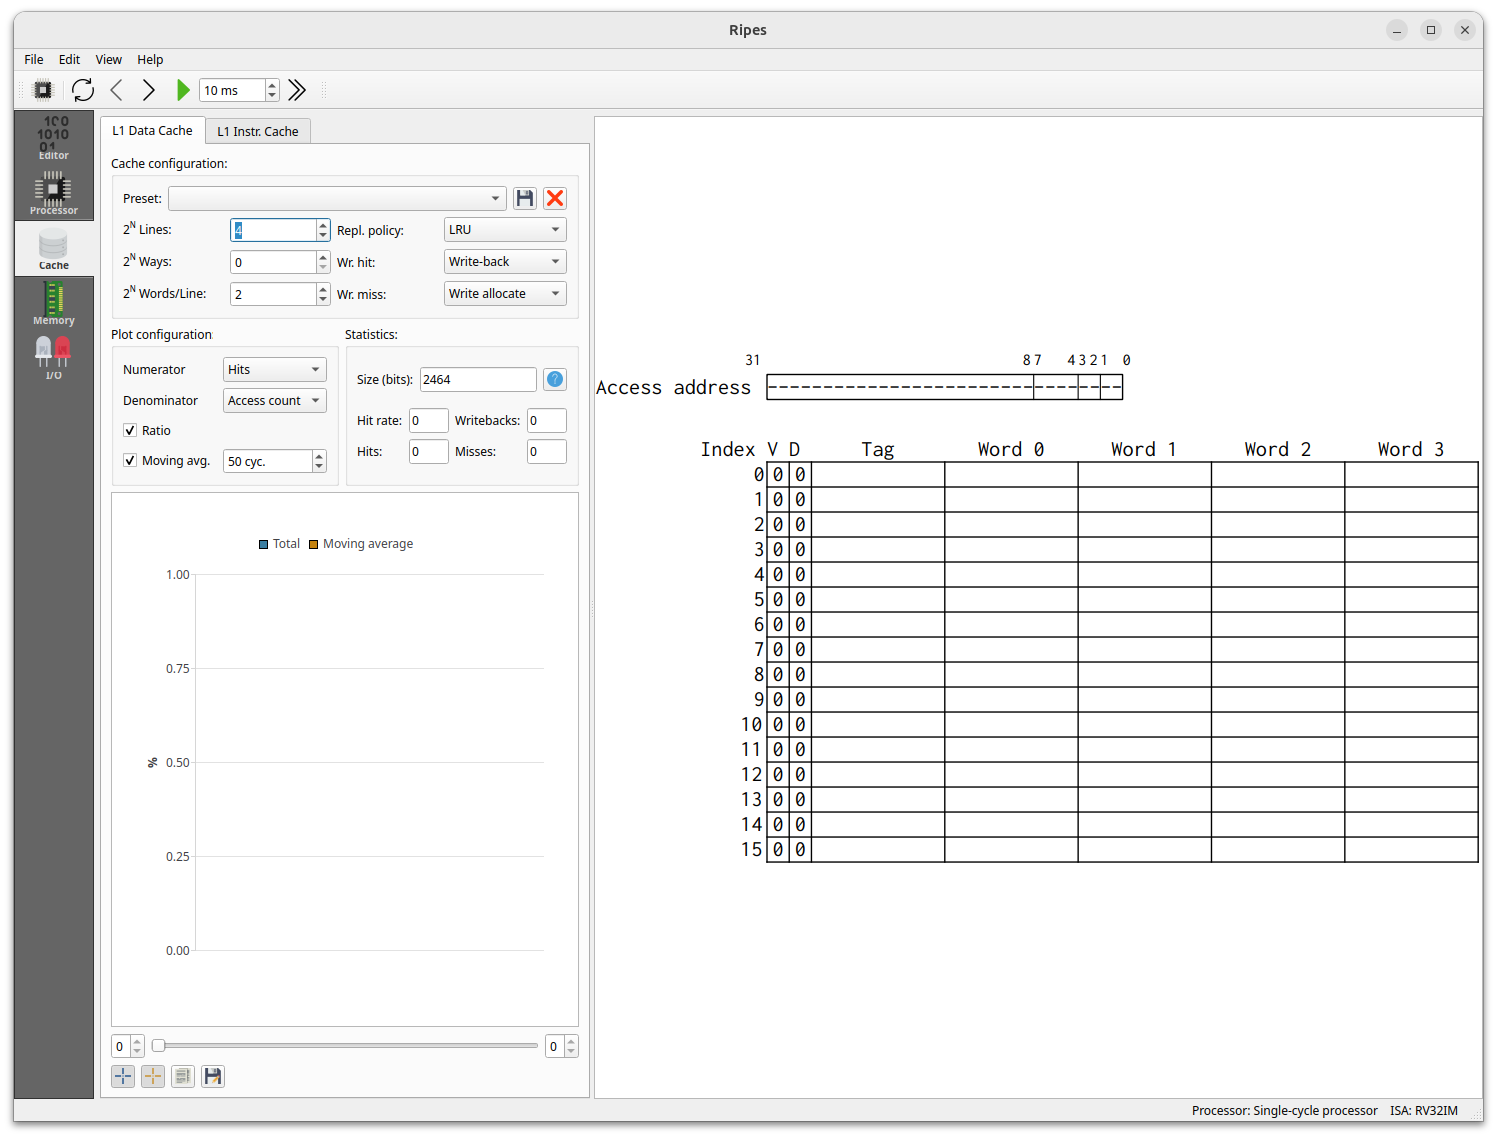

Cada una de las cachés, L1 de datos y L1 de instrucciones, se puede configurar en su correspondiente pestaña, mediante las siguientes opciones:

- **Ways (Vías)**: Asociatividad, dada como potencia de dos. Nos centraremos en simular cachés con 1 vía, también llamadas de **correspondencia directa** (*direct mapped*), por lo que estableceremos `2^N ways = 0` (2^0 = 1 vía) tanto para L1D como para L1I.
  
- **Lines (Líneas)**: Número de líneas de caché. Se especifica también como una potencia de dos. Inicialmente, estableceremos `2^N lines = 4` (2^4 = 16 líneas) para ambas cachés.

- **Words/Line (Palabras por línea)**: Número de palabras dentro de cada línea de caché. Se especifica como potencia de dos. Inicialmente, estableceremos `2^N words/line = 2` (2^2 = 4 palabras por línea) para ambas cachés.

El resto de opciones podemos ignorarlas, ya que quedan fuera del ámbito de esta práctica.

Conforme vamos configurando las cachés, podemos visualizar gráficamente el *aspecto* de la caché, según tenga más o menos líneas, o más o menos palabras por línea. Veremos gráficamente que nuestra caché se asemeja a una *tabla* que contiene tantas *filas* como líneas hayamos configurado, y tantas *columnas* como palabras por línea hayamos establecido. En cada una de las *celdas* de dicha *tabla*, la caché  puede guardar un valor de 32 bits (4 bytes, es decir, una *palabra*). Por ejemplo, en cada celda se puede guardar una instrucción RISC-V (como ocurre en la caché L1 de instrucciones) o un número entero (como ocurre en la caché L1 de datos).

## Ilustrando el principio de localidad: Multiplicación de matrices

Las cachés explotan el principio de localidad de referencia almacenando datos recientemente accedidos (localidad temporal) y datos cercanos a los utilizados (localidad espacial) para anticiparse a futuras solicitudes de acceso a memoria por parte del procesador. Esto reduce la necesidad de acceder a la memoria principal, cuyo acceso es más lento, mejorando el rendimiento al proporcionar datos rápidamente desde la memoria caché, más cercana al procesador.

Para ilustrar cómo las cachés explotan la localidad de referencia, utilizaremos como ejemplo el siguiente programa en C, que lleva a cabo la multiplicación de dos matrices cuadradas de orden 4.

```
asm("li sp, 0x100000");  // SP set to 1 MB
asm("jal main");         // call main
asm("mv a1, a0");        // save return value in a1
asm("li a7, 10");        // prepare ecall exit
asm("ecall");            // now your simulator should stop
```
```C
#define W 4  // Matrix order

void mmul(const int a[W][W], const int b[W][W], int c[W][W]) {
    for (int row = 0; row < W; row++) {
        for (int col = 0; col < W; col++) {
            for (int k = 0; k < W; k++) {
                c[row][col] += a[row][k] * b[k][col];
            }
        }
    }
}

int main() {
    int A[W][W];
    int B[W][W];
    int C[W][W];

    // Establecemos algunos valores de A y B fácilmente identificables
    A[0][0] = 0xa;
    A[1][0] = 0xaa;
    A[2][0] = 0xaaa;
    A[3][0] = 0xaaaa;
    B[0][0] = 0xb;
    B[1][0] = 0xbb;
    B[2][0] = 0xbbb;
    B[3][0] = 0xbbbb;

    mmul(A, B, C);
    return 0;
}

         
```

1. Copia el código C anterior y pégalo en la vista *Editor* de Ripes.
2. Compila el programa C a ensamblador, pulsando el botón *Compile C program* ilustrado con un martillo.
   > **NOTA**: Este programa se debe compilar pasando la opción `-nostdlib` al enlazador, como vimos en una práctica anterior: *Edit->Settings->Compiler->Linker arguments.*
4. Establece el modelo de procesador en **Single-cycle processor** usando el botón *Select processor*.

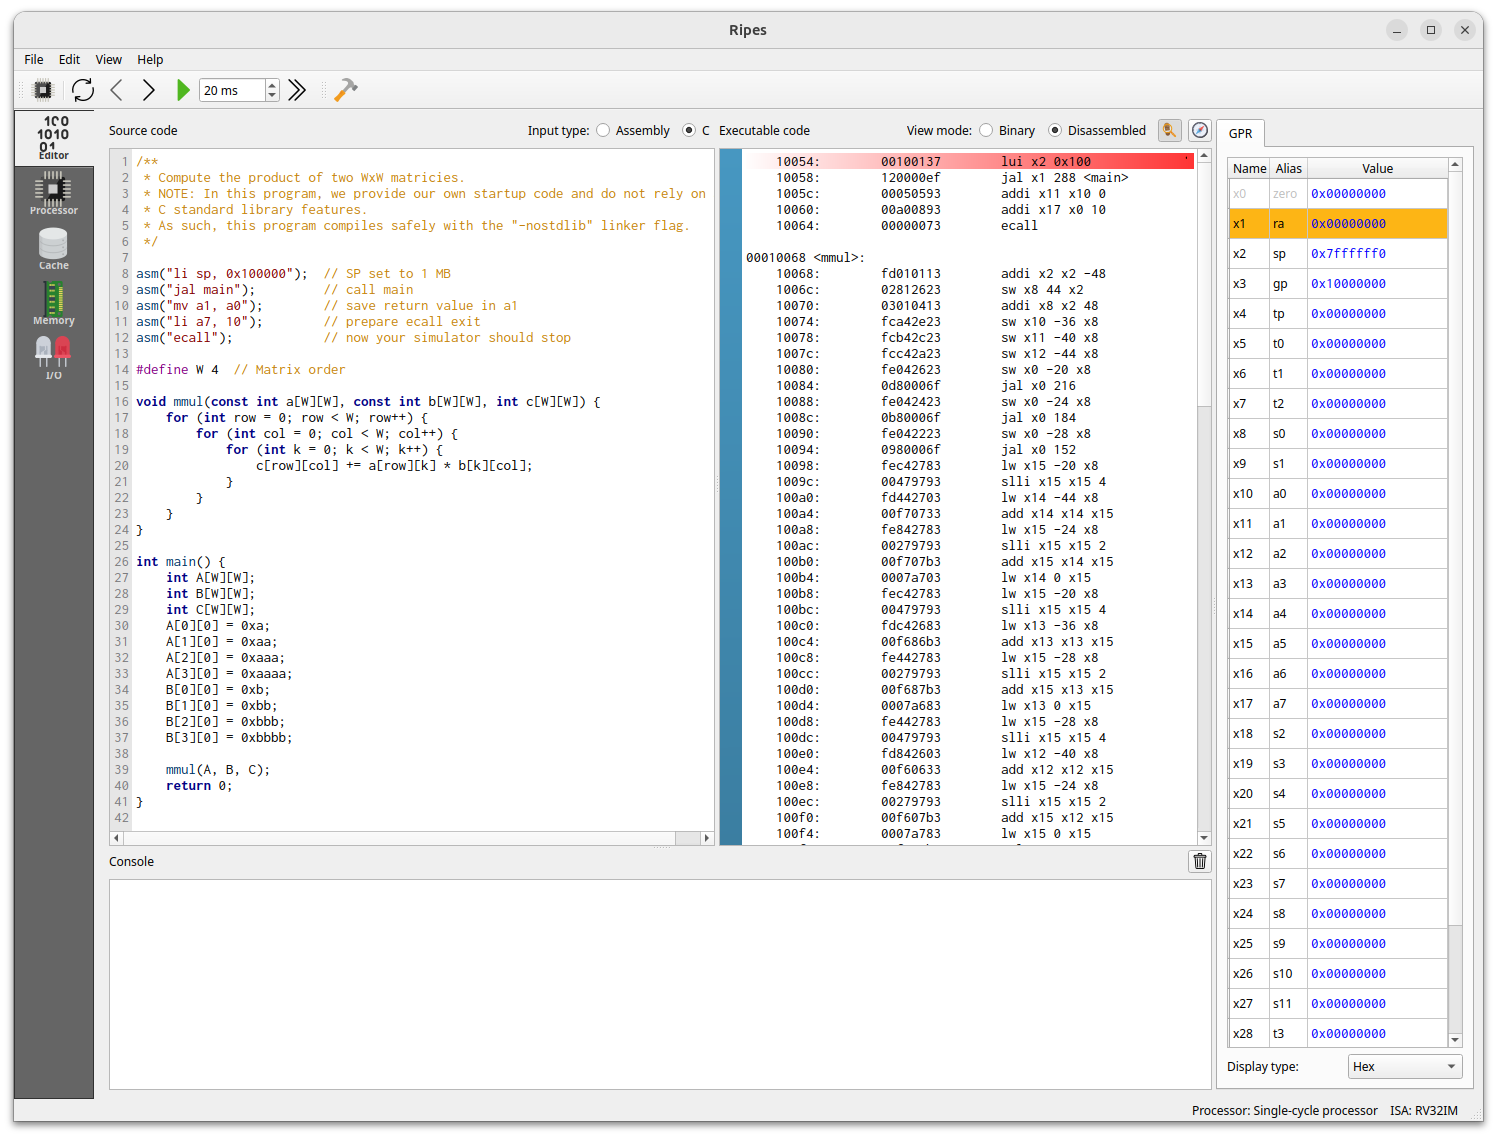

Una vez compilado, estamos en disposición de cambiar a la vista *Cache*. Resulta posible simular la ejecución del programa desde cualquier vista (*Cache* o *Editor*). Si lo hacemos desde la vista *Editor* podremos ver la instrucción ejecutada en cada momento y el valor de los registros. Si lo hacemos desde la vista *Cache*, podremos observar los fallos, aciertos y estadísticas acerca del uso de las cachés. Resulta posible cambiar de vista en cualquier momento sin que eso afecte a la ejecución de programa. Puede resultar más cómodo utilizar la tecla `F5` para avanzar la ejecución de instrucción en instrucción.

> Antes de continuar, asegúrate de haber configurado **ambas cachés** de la forma indicada anteriormente: **16 líneas, 4 palabras por línea, 1 vía**.

### Acceso a instrucciones

Empezaremos por ver la caché de instrucciones: selecciona la pestaña *L1 Instr. cache*. Simula paso a paso (tecla F5 o botón *Clock the circuit*) la ejecución de unas cuantas instrucciones del programa y observa la caché. Mientras se ejecutan las instrucciones del programa, observa los accesos a memoria que aciertan en caché: la palabra accedida en caché se coloreará de verde. Por su parte, los accesos que resultan en un fallo de caché colorean en rojo la palabra obtenida de la memoria principal con el dato requerido. También podemos ver cómo evolucionan las estadísticas de accesos a memoria: aciertos  (*hits*) y fallos (*misses*), tasa de acierto (*hit rate*) así como una representación gráfica de la tasa de acierto, calculada como:  *aciertos / (aciertos+fallos)*.

Como las cachés están inicialmente vacías (es decir, todas las líneas de la caché tienen el bit de validez V a 0), los primeros accesos a memoria por parte de la CPU para obtener (*fetch*) las instrucciones del programa no suelen acertar en caché. Esto se conoce como fase de *warmup* o *calentamiento* de las cachés. Durante un tiempo se producirán fallos en caché (rojo) al obtener por primera vez una instrucción, si bien los siguientes accesos a las tres instrucciones que hay inmediatamente a continuación acertarán (verde) puesto cada fallo de caché no sólo trae desde memoria la instrucción en la dirección solicitada, sino que obtiene un **bloque** del tamaño de una línea, en este caso, un bloque de memoria que contiene 4 instrucciones consecutivas. 

PREGUNTA: Observa cómo, tras cada fallo, se suelen producir aciertos en otras palabras del mismo bloque (índice de la caché). ¿Qué propiedad del programa está aprovechando la caché de instrucciones cuando acierta en caché al obtener la instrucción que sucede a la ejecutada anteriormente? Explica por qué los programas exhiben dicha propiedad en el acceso a las instrucciones.

RESPUESTA: La propiedad que aprovecha es la localidad espacial, ya que los programas suelen ejecutarse secuencialmente y las instrucciones consecutivas suelen estar ubicadas cercas unas de otras en memoria.


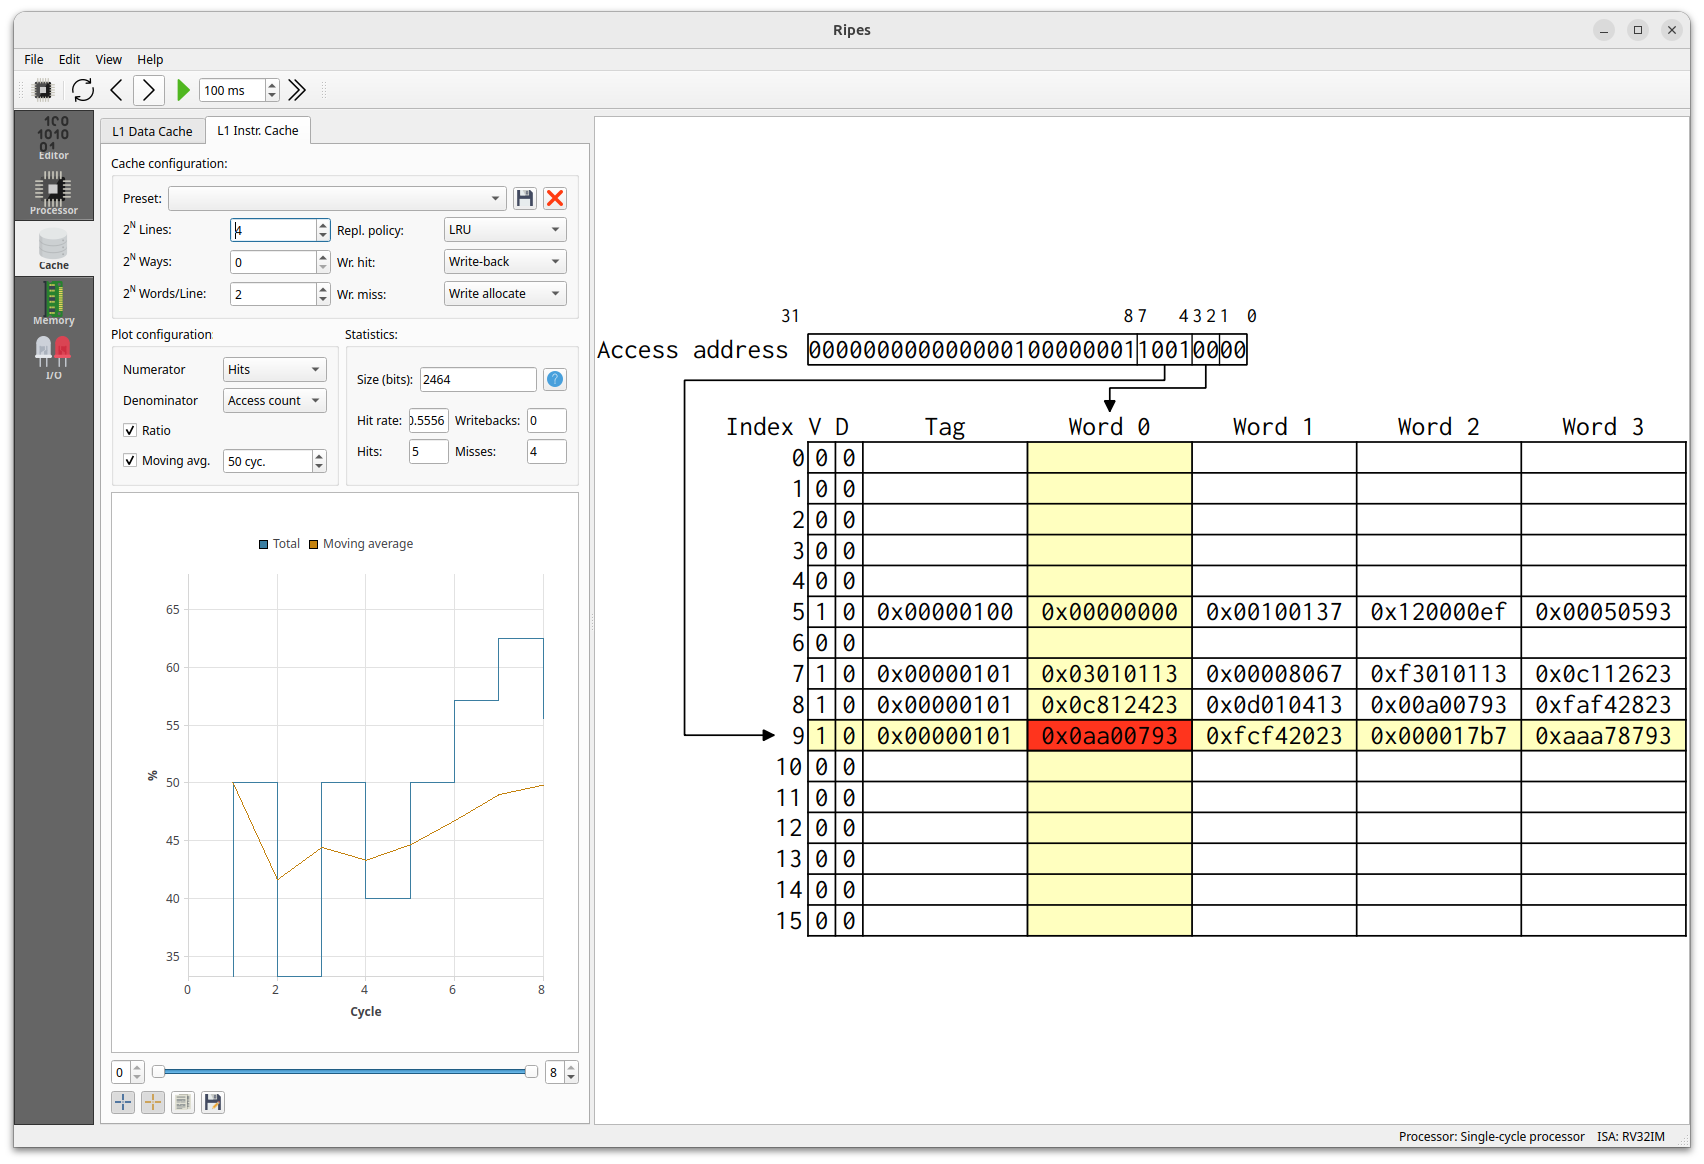

Presiona F5 repetidamente para avanzar en la simulación. Observa cómo, una vez que la caché se llena de bloques con instrucciones, la mayoría de accesos se vuelven aciertos (verde). En el gráfico de tasa de acierto, verás que a partir del ciclo 80 la tasa empieza a crecer continuamente, puesto que ya han obtenido desde memoria todos los bloques con las instrucciones que se están ejecutando en ese momento: los que contienen el código máquina de la función `mmul`. A partir de ese momento, no se produce ningún fallo, lo cual indica que ya ha concluido la fase de *calentamiento*.

PREGUNTA: ¿Qué propiedad de los programas está aprovechando a partir del ciclo 80 la caché de instrucciones? Explica por qué los programas generalmente exhiben dicha propiedad en el acceso a las instrucciones.

RESPUESTA: Se está aprovechando la localidad temporal. Porque en términos generales, los programas están compuestos por bucles y por tanto hay ciertas instrucciones que se repiten ya que si no hubiera bucles el programa tendría muchas más instrucciones.



PREGUNTA: ¿Cuántos bytes ocupan en memoria las instrucciones de la función `mmul` (su código máquina)?  

RESPUESTA: Ocupa 220 bytes.


PREGUNTA: ¿Cuántos datos puede almacenar la caché configurada?

RESPUESTA: Puede almacenar 256(2**8) datos



PREGUNTA: Pasa a la vista *Editor* y ejecuta el programa, manteniendo F5 pulsado, y trata de localiza las instrucciones que forman el bucle anidado más interno de `mmul`. ¿En qué dirección de memoria se ubica la instrucción de salto condicional del bucle anidado más interno? NOTA: El código ensamblador del salto te indica cuántos bytes se salta *hacia atrás*.

RESPUESTA: Se encuentra en la dirección 0x10134


PREGUNTA: ¿En qué dirección de memoria se ubica la primera instrucción del bucle anidado más interno? ¿Cuántos bytes ocupan las instrucciones de dicho bucle interno? 

RESPUESTA: Se encuentra en la dirección 0x100c8 y ocupa 44 bytes


PREGUNTA: ¿Cuántos bytes ocupan las instrucciones de `mmul`, contando desde el comienzo del bucle más externo? NOTA: Localiza el salto condicional que aparece más cerca del final de la función, y su destino. Puedes poner un *breakpoint* y ejecutar hasta dicho punto con el botón ">>".

RESPUESTA: Ocupan 224 bytes.



PREGUNTA: Relaciona el tamaño que ocupan las instrucciones que conforman el bucle triplemente anidado de `mmul` con el tamaño de la caché, y explica por qué no se producen fallos de caché una vez pasada la fase de calentamiento.

RESPUESTA: Como tenemos 256 bytes, pero son 224 bytes nos caben todos los bytes dentro de la cache, es decir, nos cabe todo el bucle dentro de la caché sin problema.


### Acceso a datos

Resetea la simulación con el botón de *Reset*. Luego, simula manteniendo pulsada la tecla F5 hasta el ciclo 81, y observa cómo se ha accedido a los datos de la fila 0 de A y la fila 0 de B (Recuerda: A[0][0] vale 0xa y B[0][0] vale 0xb). Continúa simulando hasta el ciclo 197, y verás que la matriz B al completo está ya en caché. A partir de ese momento, la caché ya tiene todos los datos necesarios para ejecutar la primera iteración del bucle más externo (recorrer la primera fila de A y toda la matriz B), por lo que durante muchos ciclos no se produce ningún fallo.

Simulas paso a paso durante unas decenas de accesos y observa que el programa accede repetidamente a los elementos de la fila 0 de A (cuyo primer elemento tiene el valor 0xa). Luego, simula con F5 hasta el ciclo 756, y verás cómo hasta ese ciclo no se produce ningún fallo adicional: el número de fallos se mantiene en 13 durante casi 700 ciclos (desde el ciclo 62). Esto es gracias a que todos los datos que conforman el conjunto de trabajo de los dos bucles anidados más internos están ya en caché. Por tanto, vemos que durante todos esos ciclos la caché está permitiendo aprovechar la **localidad temporal** en el acceso a los elementos de la matriz B, y a la primera fila de las matrices A y C. 

Simula de nuevo lentamente, paso a paso, viendo que el programa ahora accede repetidamente a los elementos de la fila 1 de A (cuyo primer elemento tiene el valor 0xaa). Luego, simula con F5 hasta el ciclo 1452  (puedes mantener la tecla pulsada), y verás cómo hasta ese ciclo no se produce ningún fallo adicional: el número de fallos se mantiene en 14 durante otros casi 700 ciclos (desde el ciclo 756). Durante todos esos ciclos la caché de datos está permitiendo aprovechar la **localidad temporal** en el acceso a los elementos de la matriz B, y a la segunda fila de las matrices A y C.

Por último, simula la ejecución del programa hasta su terminación.  Una vez ejecutado hasta el final, deberías ver las estadísticas y estado de la caché tal y como se muestra en la imagen siguiente.  Fíjate que gracias a los valores iniciales que les hemos asignado a las matrices A y B, podemos ver en qué líneas de la caché L1D se ubican sus datos.

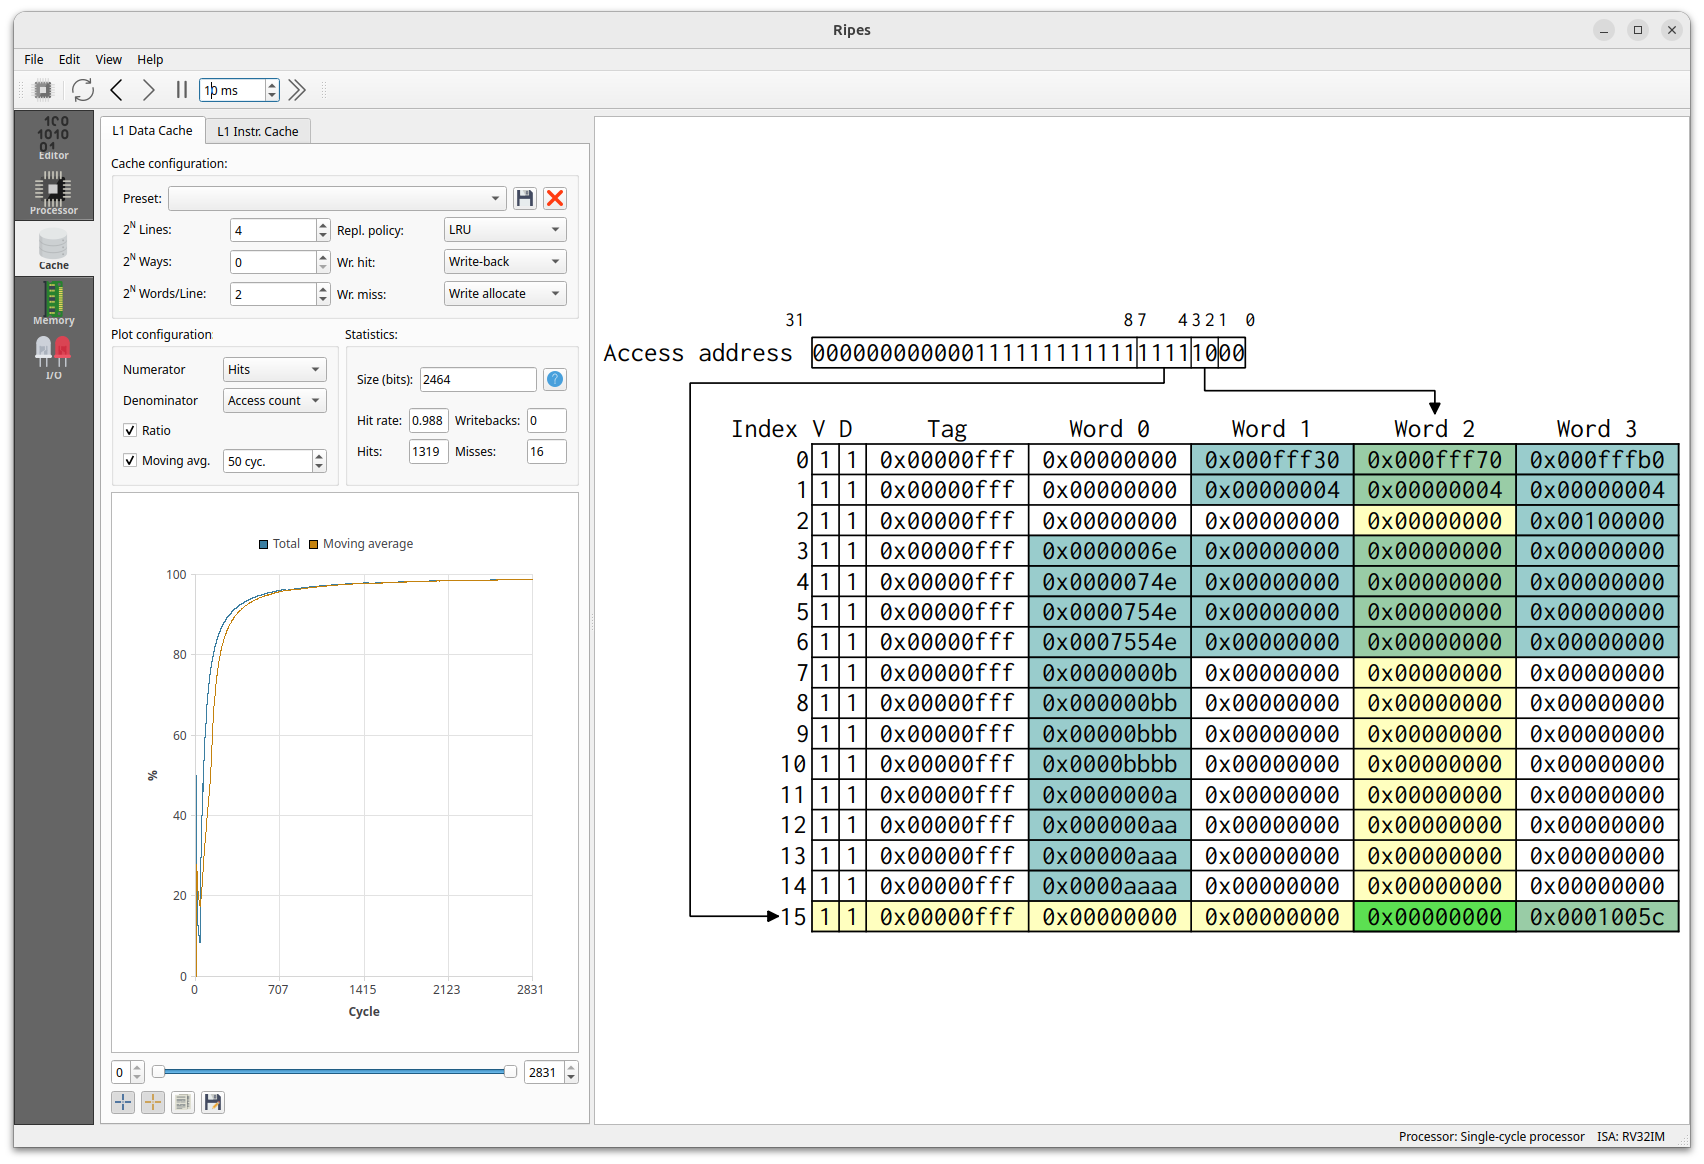

PREGUNTA: ¿Cuál es el tamaño de cada matriz de 4x4 elementos? 

RESPUESTA: Una matriz ocupa 64 bytes, es decir, 2**6 bytes. Como son 3 matrices, 64 por 3 = 192 bytes es el tamaño de las tres matrices. 


PREGUNTA: Con la configuración actual de la caché, ¿es posible mantener en caché los datos de las matrices A, B y C durante la ejecución del programa?

RESPUESTA:  Como caben las 3 matrices en caché ya que no superan los 256 bytes es posible mantener en caché los datos de las 3 matrices durante la ejecución del programa.



PREGUNTA:  Teniendo en cuenta que el elemento A[3][0] tiene el valor 0xaaaa y que las matrices se almacenan en memoria por filas (los elementos de la misma fila se ubican consecutivamente en memoria), ¿en qué índice de la caché están almacenados los elementos de la fila 3 de A? ¿Y los de la fila 2 de B?

RESPUESTA: Los elementos de la fila 3 de A están almacenados en el índice 14 y los elementos de la fila 2 de B en el índice 9



PREGUNTA: ¿Cuántos aciertos en caché de datos se han producido? ¿Cuántos fallos? ¿Cuál es la tasa de acierto conseguida?

RESPUESTA: Se han producido 1319 aciertos y 16 fallos. La tasa de aciertos es 0.9887


Esto es una clara muestra de que el programa de multiplicación de matrices exhibe una altísima localidad de referencia en el acceso a los datos, localidad que puede ser aprovechada por una simple caché de 256 bytes de tamaño.

### Impacto en el tiempo de ejecución del programa.

**Penalización por el acceso a instrucciones.**

Observa el número de instrucciones ejecutadas en la pestaña de L1I: puesto que tenemos 2806 aciertos y 32 fallos de caché, en total se han ejecutado 2838 instrucciones para completar el programa. La tasa de acierto en la caché L1I es muy elevada (0.989). Sin la caché de instrucciones, cada uno de los 2838 accesos a obtener una instrucción tendría que haber pagado la penalización de acceder a la memoria principal, mucho más lenta que el procesador.

PREGUNTA: El procesador simulado ejecuta una instrucción por ciclo, ya que hemos elegido el modelo de procesador *Single-cycle processor*). Ignorando el tiempo empleado en el acceso a los datos del programa, ¿cuántos ciclos se emplearían en ejecutar el programa, si no tuviésemos la caché de instrucciones, asumiendo que cada acceso a memoria a obtener una instrucción supone una penalización extra de 100 ciclos?

RESPUESTA: Si cada acceso a memoria supone una penalización de 100 ciclos cada instrucción tardaría en ejecutarse 1 ciclo sumado a los 100 ciclos de penalización es decir, tardaría en ejecutarse 101 ciclos. Como el total de instrucciones es 2838; 2838x101= 286638 ciclos necesarios para ejecutar el programa completo.



PREGUNTA: De nuevo ignorando el acceso a los datos del programa, ¿cuántos ciclos se emplearían en ejecutar el programa con la caché de instrucciones simulada? Asume la misma penalización por acceso a memoria (100 ciclos), mientras que obtener las instrucciones de la caché L1I supone una penalización de 2 ciclos, que se suma al ciclo que tarda la instrucción en ejecutarse.

RESPUESTA: Cuando se produce un acierto, es porque la instrucción ha accedido a caché y por tanto como hay 2806 aciertos y cada uno de esos aciertos usa 3 ciclos para ejecutarse 2806x3=8418 ciclos en ejecutarse los aciertos, mientras que para los fallos, como estos no acceden a caché, sino que acceden a memoria, al haber 32 fallos, 32x101 = 3232 ciclos en ejecutarse los fallos. Por lo tanto, si susamos ambos(8418+3232), que es el programa en conjunto obtenemos 11650 que es el número de ciclos en los que se ejecuta el programa.



PREGUNTA: Calcula el *speedup*, es decir, cuántas veces más rápido se ejecutaría el programa con y sin caché L1I (Ciclos con  L1I / Ciclos sin L1I).

RESPUESTA: Al hacer la división(286638/11650) obtenemos aproximadamente 24.6 por lo que el programa se ejecutaría 24.6 veces más rapido con caché que sin ella.


**Penalización por el acceso a datos.**

Ahora vamos a ver cuántos ciclos adicionales habría que sumar por culpa del acceso a datos. Consideraremos que aquellas instrucciones que acceden a datos (como `lw`, `sw`) al ejecutarse pagan una penalización extra de 2 ciclos si el dato se obtiene de la caché de datos L1D, y de 100 ciclos si el dato se obtiene de memoria.

PREGUNTA: ¿Cuál sería la penalización que habría que sumar debida al acceso a los datos cuando se usa la caché de datos? ¿Y sin caché de datos?

RESPUESTA: En este caso habría 1319 aciertos y 16 fallos de la caché. Por tanto, al multiplicar 1319 x (2 + 1), es decir, 1319 x 3 y se lo sumamos a los fallos de la caché,es decir, se lo sumamos a 16 x (100+1), que es 16 x 101, obtenemos 5573 ciclos.



PREGUNTA: Gracias a la existencia de las cachés de datos e instrucciones que hemos simulado, ¿cuál sería el número de ciclos que tarda en ejecutarse el programa, teniendo en cuenta tanto la penalización por acceso a datos y por acceso a instrucciones, y la ejecución de dichas instrucciones?

RESPUESTA: Sumando los dos últimos resultados obtenemos: 286638 + 5573 = 292211 ciclos



### La influencia de la configuración de la caché en la tasa de acierto

**Tamaño del caché**.

Reduce el tamaño de la caché de instrucciones a 8 líneas, frente a las 16 que teníamos hasta ahora. Luego, simula los primeros 800 ciclos. Observa el gráfico de la tasa de acierto de la caché de instrucciones y responde a las siguientes preguntas.

PREGUNTA: ¿Qué diferencias observas entre lo que está ocurriendo con la tasa de acierto ahora y lo que ocurría con la caché de 16 líneas? ¿A qué se debe el comportamiento diferente? Relaciona con el tamaño del código que se ejecuta, según vimos en un ejercicio anterior.

RESPUESTA: La tasa de acierto es mucho menor(por tanto la tasa de fallos es mayor) ya que los bucles no caben en los 128 bytes de la caché.



PREGUNTA: Termina de simular la ejecución del programa. ¿Cuál es la tasa de acierto de L1I?

RESPUESTA: La tasa de acierto es 0.9901



**Tamaño del bloque (palabras por línea)**.

Ahora aumenta el tamaño de la caché de instrucciones a 32 líneas, y reduce el número de palabras por línea a 1. El resultado será una caché con la misma capacidad que la del punto anterior, pero con 4 veces más líneas (32 frente a 8), y cada una de estas líneas con 4 veces menos palabras (1 frente a 4). Simula la ejecución del programa hasta su finalización mientras observas el gráfico de la tasa de acierto de la caché de instrucciones y responde a las siguientes preguntas.

PREGUNTA: ¿Qué diferencias observas entre lo que está ocurriendo con la tasa de acierto ahora y lo que ocurría con la caché de 8 líneas y 4 palabras por línea? ¿A qué se debe el comportamiento diferente? 

RESPUESTA: La principal razón del comportamiento diferente es la falta de aprovechamiento de la localidad espacial en la nueva configuración de caché. Al reducir el tamaño de cada línea de caché a solo una palabra, se pierde la ventaja de traer bloques contiguos de instrucciones o datos, lo que resulta en más fallos de caché y una menor tasa de acierto.



## Ilustrando el funcionamiento de una caché: Suma de los elementos de un array

Las cachés explotan el principio de localidad de referencia almacenando datos recientemente accedidos (localidad temporal) y datos cercanos a los utilizados (localidad espacial) para anticiparse a futuras solicitudes de acceso a memoria por parte del procesador. La pregunta que surge es, ¿cómo localizamos si el dato o instrucción que buscamos está ya en caché? La respuesta es: necesitamos una forma de hacer corresponder a cada **bloque de memoria** (conjunto de bytes contiguos del tamaño de una línea de caché), un índice en la caché:

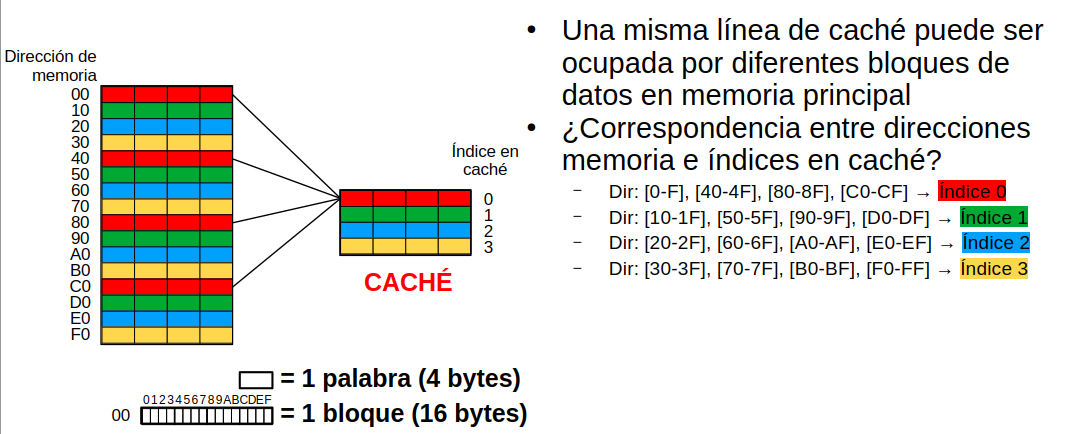

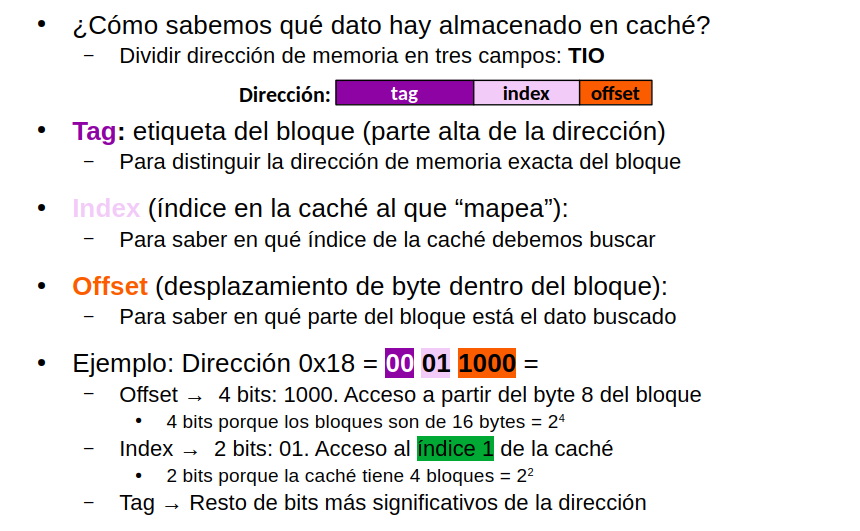

Para ilustrar cómo se ubican los bloques en caché y se determina si un acceso es un acierto o un fallo, vamos a utilizar un sencillo programa que suma los elementos de un array de 16 enteros:


```asm
      .data
array:  .word 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16

      .text
main: 

    la x9, array            # “load address”
    add x10,x0,x0           # sum=0
    add x11,x0,x0           # i=0
    addi x13,x0,16          # 16 elementos en el array
loop:
    bge x11,x13,done        # jump if i>=16
    lw x12, 0(x9)           # leer array[i] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]
    addi x11,x11,1          # ++i
    j loop
done: 
    li a7,1                 # printInt (a0=x10: sum)
    ecall
    li a7,10                # exit
    ecall
    nop
```

Copia el código ensamblador anterior y pégalo en Ripes, en la vista *Editor* (*puede que tengas que cerrar y volver a abrir Ripes tras el ejercicio anterior*). Fíjate que en este caso, las instrucciones del programa empiezan en la dirección de memoria 0 (puedes ver la dirección en el panel derecho, junto al código máquina):
   

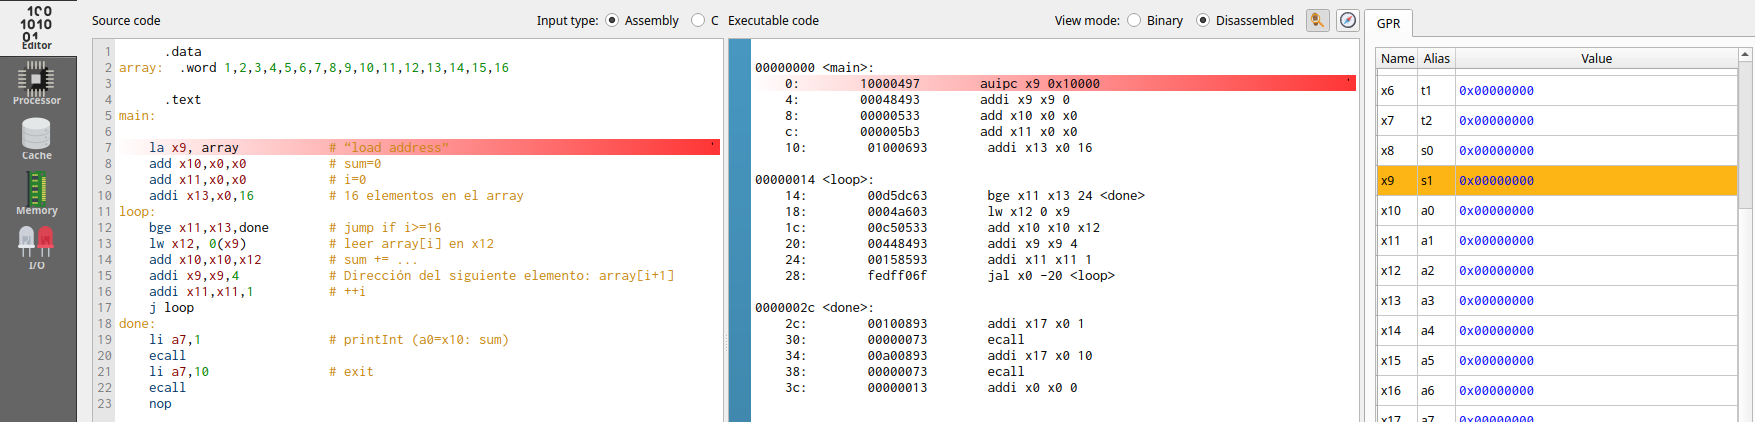

Configuramos una caché de instrucciones de correspondencia directa (1 vía), 4 líneas y 4 palabras por línea, como se muestra a continuación. Como puedes ver, el primer acceso a la L1I será a la dirección 0, que en este caso es la de la primera instrucción del programa: ` 0:        10000497        auipc x9 0x10000`.

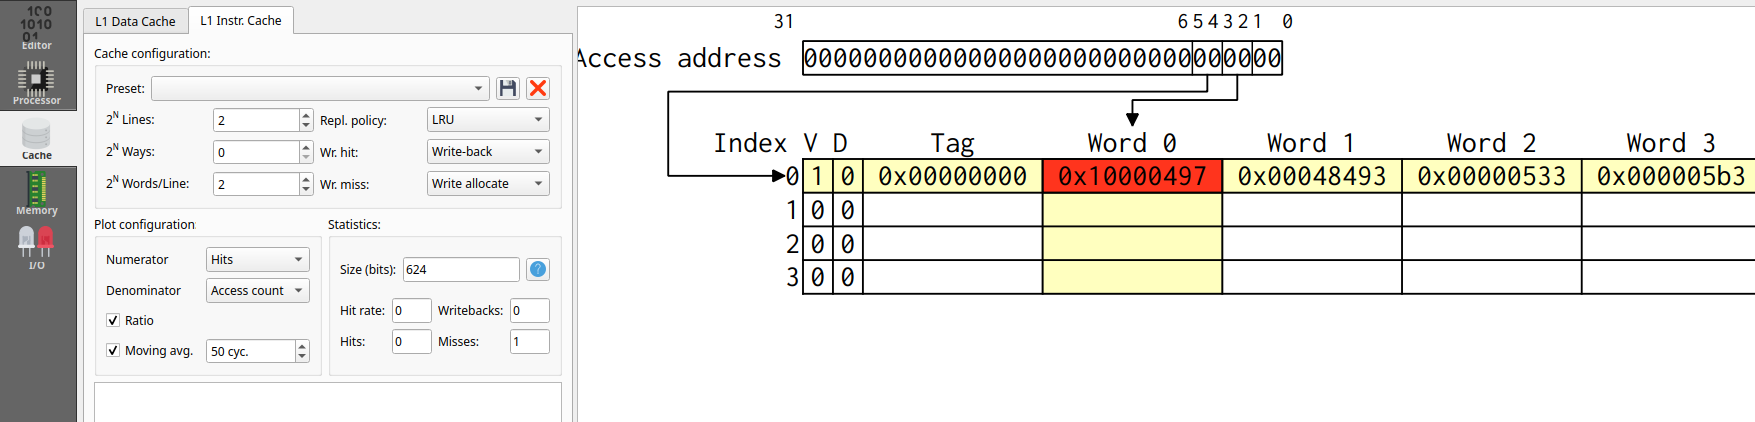

Como vemos, la dirección de memoria de 32 bits se divide en **Tag**, **Index** y **Offset**.

- El campo *offset* de la dirección indica a qué parte de la línea de caché tenemos que acceder para encontrar los datos: a su vez, se puede dividir en offset a nivel de *palabra* (qué palabra del bloque) y offset a nivel de byte dentro de la palabra (byte dentro de la palabra). Puesto que estamos trabajando con instrucciones que ocupan una palabra (4 bytes), los últimos dos bits de las direcciones de las instrucciones del programa siempre serán `00`, puesto que las direcciones donde comienzan las instrucciones siempre son múltiplo de 4.
    - En el caso de la dirección de memoria 0, debemos acceder a la palabra 0 del bloque, ya que los bits 3 y 2 valen 00, como vemos en la imagen anterior.
- El campo *index* de la dirección indica en qué índice de la caché tenemos que buscar el dato/instrucción. En este caso, son necesarios 2 bits de la dirección, a continuación del offset, puesto que tenemos 4 líneas en caché, de la 0 a la 3.
    - En el caso de la dirección de memoria 0, debemos acceder al índice 0 de la caché, ya que los bits 5 y 4 valen 00, como vemos en la imagen anterior.
- El campo *tag* de la dirección se utiliza para etiquetar el bloque de datos en caché y así poder distinguirlo de otros bloques que también corresponden al mismo índice de la caché.
    - En el caso de la dirección de memoria 0, los bits 31 al 6 valen 00...000, como vemos en la imagen anterior, por lo que el *tag* será 0x00000000.

**Manejo de un fallo de caché.**

Puesto que inicialmente la caché está vacía, todos los bits de válido (V) de todas las líneas están a 0, indicando que no hay datos copiados desde memoria. Así pues, ante el acceso a la dirección de memoria 0 para obtener la primera instrucción del programa, el controlador de caché busca en el índice 0 y al ver el bit de válido a 0, se produce un fallo de caché. Este tipo de fallos se conoce como **fallos en frío** y como hemos visto, ocurren durante la etapa de *calentamiento*, al comienzo de la ejecución de un programa. 

Para resolver el fallo, se obtiene de la memoria principal (más lenta, ya que está fabricada con tecnología DRAM) el bloque correspondiente a las direcciones de memoria de la 0 a la 15 (4 palabras de 4 bytes) y se inserta en la caché, en el índice 0 (bits 5 y 4), estableciendo el bit de válido (V) a 1 y el valor del *tag* correspondiente a dicho bloque (0x0000000). De esta forma, los siguientes accesos por parte de la CPU a las direcciones 0 a la 15 podrán resolverse sin necesidad de ir a la memoria principal. Finalmente, se lee la palabra 0 del bloque, según indican los bits 3 y 2 de la dirección. En esa parte del bloque (bytes 0 al 3) es donde está la instrucción a ejecutar, cuyo código máquina es 0x10000497.

**Acierto de caché.**

Tras ejecutar la primera instrucción, se actualiza el contador de programa. Al no tratarse de un salto, el PC pasa a valer 4: apunta a la segunda instrucción del programa, que es la que se ubica en memoria justo tras la anterior.

Por tanto, se accede a la cache L1I en buscar de la palabra (4 bytes) en la dirección 4. Como los bits 5 y 4 valen 00, resulta en un acceso al índice 0. Esta vez el bit de válido de la línea vale 1, por lo que para ver si se trata del dato que estamos buscando, hemos de comprobar si el *tag* de la dirección 4 coincide con el *tag* del bloque que hay en el índice 0. En este caso se produce una coincidencia, por lo que se trata de un acierto de caché, y la caché responde con el dato contenido en la palabra 1, según indican los bits 3 y 2 de la dirección. 

Los siguientes accesos a memoria son a las direcciones 8 y c, que ya que ninguna de las primeras cuatro instrucciones es un salto. Estos accesos resultan igualmente en aciertos de caché sobre el índice 0, ya que la tercera y cuarta instrucción del programa se ubican en el mismo bloque que la primera (dirección 0) y la segunda (dirección 4), pero en las palabras 2 y 3, respectivamente.

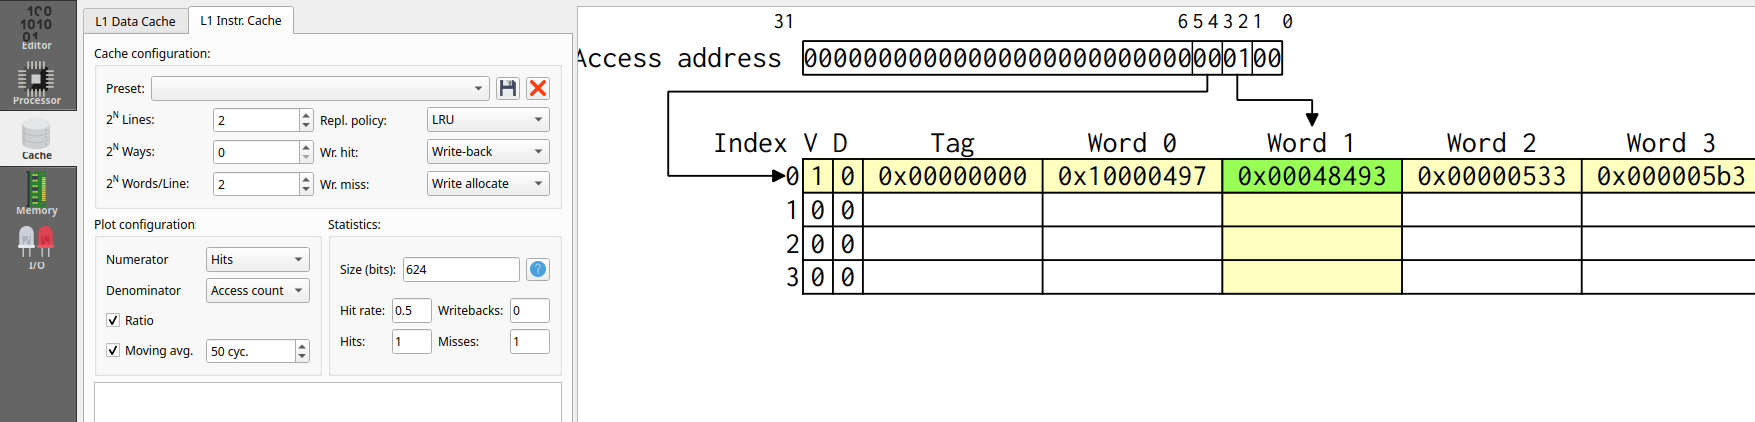

La siguiente instrucción en ejecutarse está en la dirección 0x10 = 0001 0000. En este caso, se accede al índice 1, pues los bits 5 y 4 valen 01, y se produce un fallo de caché puesto que el bit de válido está a 0. Se inserta el bloque de 16 bytes obtenido desde memoria, se establece el tag con los 26 bits de más peso de la dirección y se activa el bit de válido. De esa forma, los siguientes tres accesos, a las instrucciones en las direcciones 14, 18 y 1c, resultarán en aciertos de caché, y leerán de caché, respectivamente, la palabra 1, 2 y 3 del bloque en el índice 1.

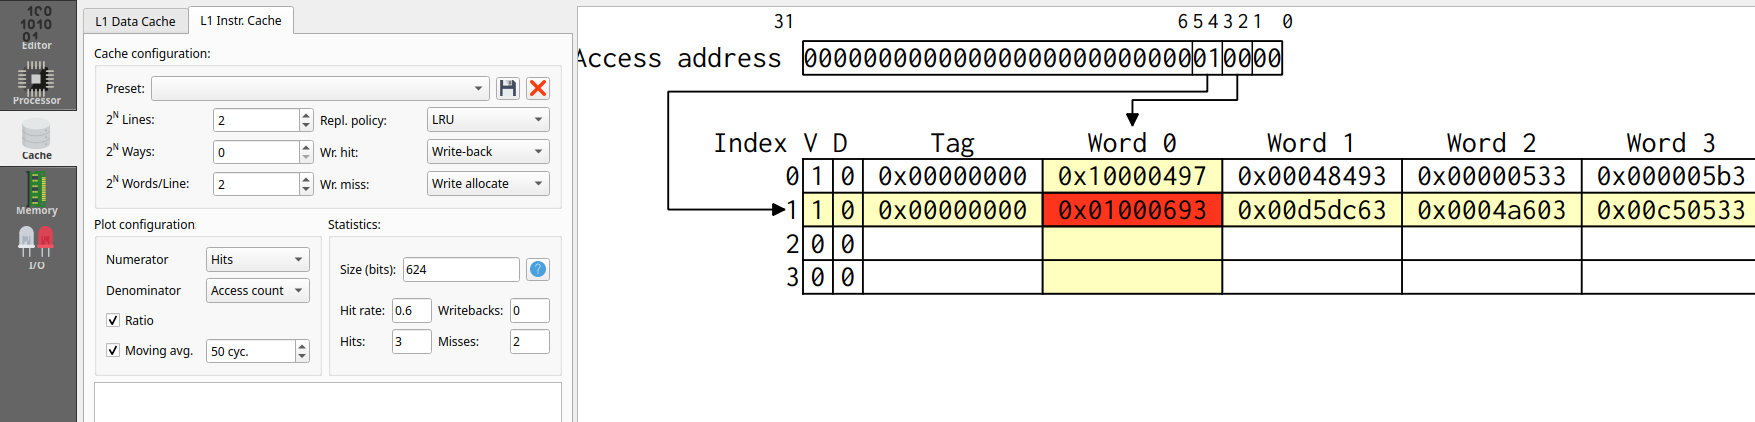

Las siguientes instrucciones hasta llegar a la instrucción en la dirección 0x28 van causando los correspondientes *fallos en frío* y posteriores aciertos de caché, explotando la **localidad espacial** que exhibe la ejecución de código secuencial.

Al llegar a la instrucción 0x28, que se trata de un salto incondicional (`j loop`) que hace que se vuelva a ejecutar la primera instrucción del cuerpo del bucle (marcada con la etiqueta `loop`): el flujo de ejecución secuencial se rompe y la CPU continúa ejecutando la instrucción en la dirección 14.

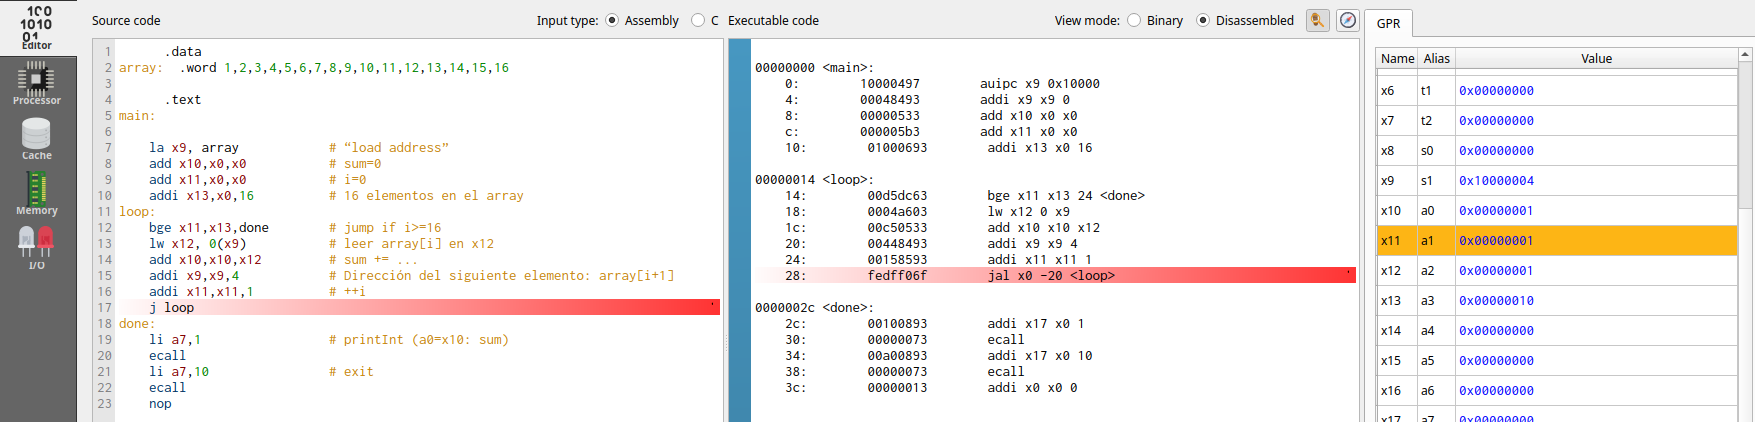

El acceso a la dirección 14 en este caso supone un acierto de caché, mostrando esta vez cómo la caché es capaz de explotar la **localidad temporal** que exhibe el acceso a las instrucciones, ya que la existencia de bucles en los programas hace muy probable el que una instrucción que acaba de ser accedida por el procesador, vuelva a ser accedida de nuevo en el futuro próximo.

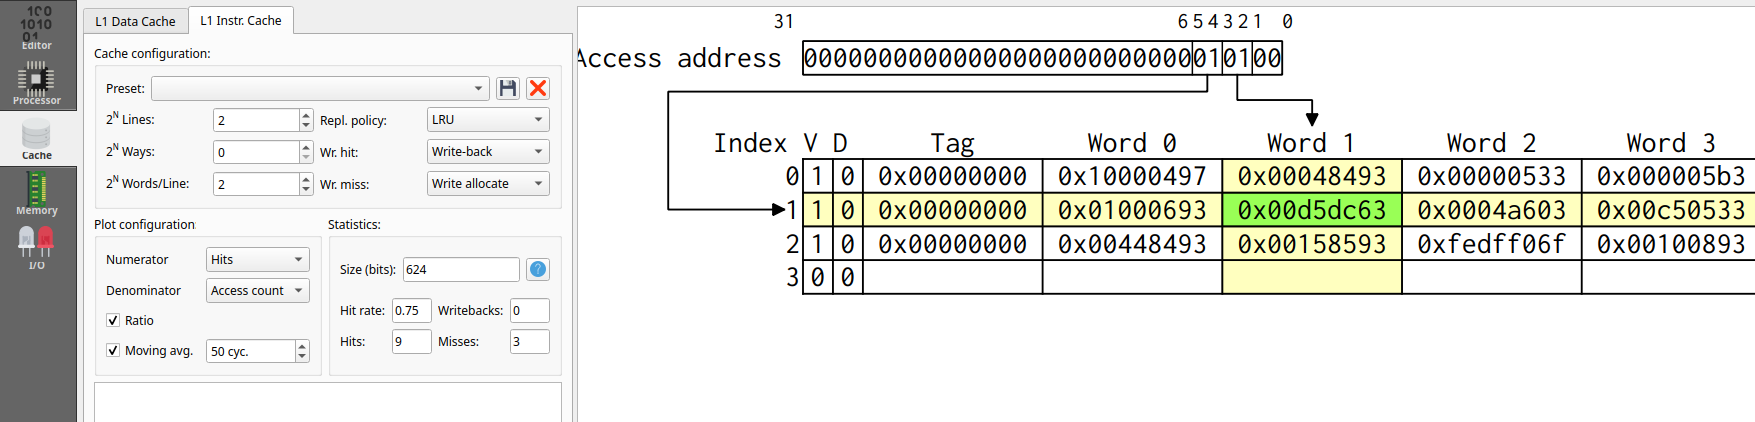

El programa recorre un array de 16 elementos y en cada iteración se accede a un elemento del array. En este punto, se ha completado la primera iteración (acceder a `array[0]`) y se empieza con la segunda. La ejecución de las siguientes 15 iteraciones del bucle resultará en aciertos en la caché de instrucciones, ya que todas las instrucciones del bucle están en la L1I. Finalmente, cuando se cumpla la condición del salto `bge` y se salga del bucle, se producirá un fallo de caché al acceder a la instrucción en la dirección 0x30, pues el índice 3 (0x30 = 11 0000 -> Bits 5 y 4 = 11) no contiene un bloque válido. Se obtendrá de memoria dicho bloque con las instrucciones ubicadas en las direcciones 30 a las 3c, si bien la instrucción en 3c nunca llega a ejecutarse puesto que el programa termina en la instrucción 38 (llamada al sistema *exit*).

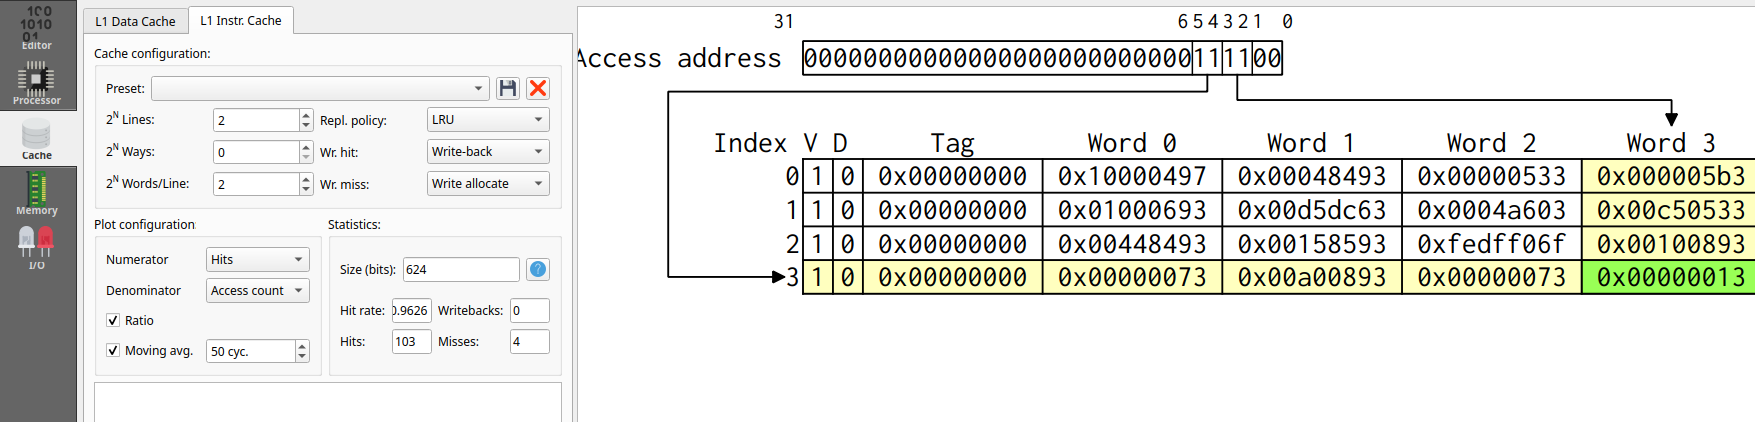

PREGUNTA: A la vista del número de aciertos y fallos de caché que se producen en la L1I, ¿cuántas instrucciones se han ejecutado para completar el programa?

RESPUESTA: Se han ejecutado 107 instrucciones(103 aciertos y 4 fallos)



Finalmente, vemos en las estadísticas que el programa ha obtenido una tasa de acierto del 0.962 en la caché de instrucciones, con 103 aciertos sobre 107 instrucciones ejecutadas.

### Localidad en el acceso a los datos

Vamos a observar ahora el patrón de acceso a memoria sobre los datos del programa. Recordemos que se trata de un programa que recorre un array de 16 elementos de tipo entero, y suma sus valores. 

Como podemos ver en la siguiente imagen, la dirección de comienzo del array es la 0x1000000 (el valor que la instrucción `la x9, array` establece en el registro x9 y que será utilizado posteriormente para leer de dicha dirección y sucesivas).

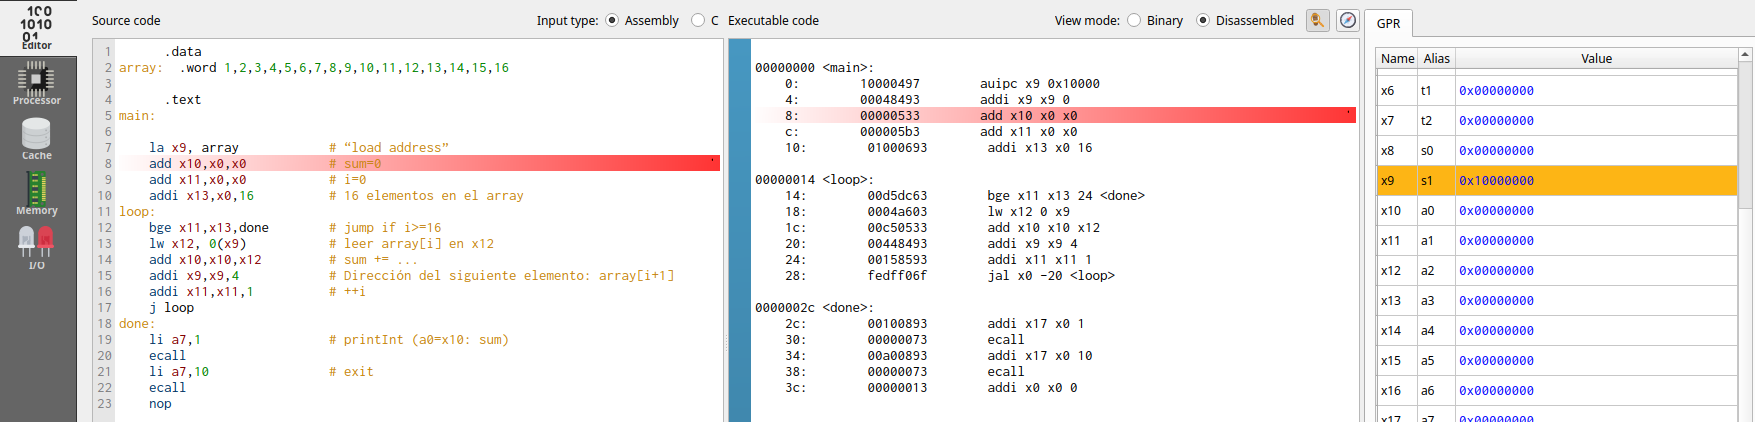

Vemos que la caché de datos está inicialmente vacía:

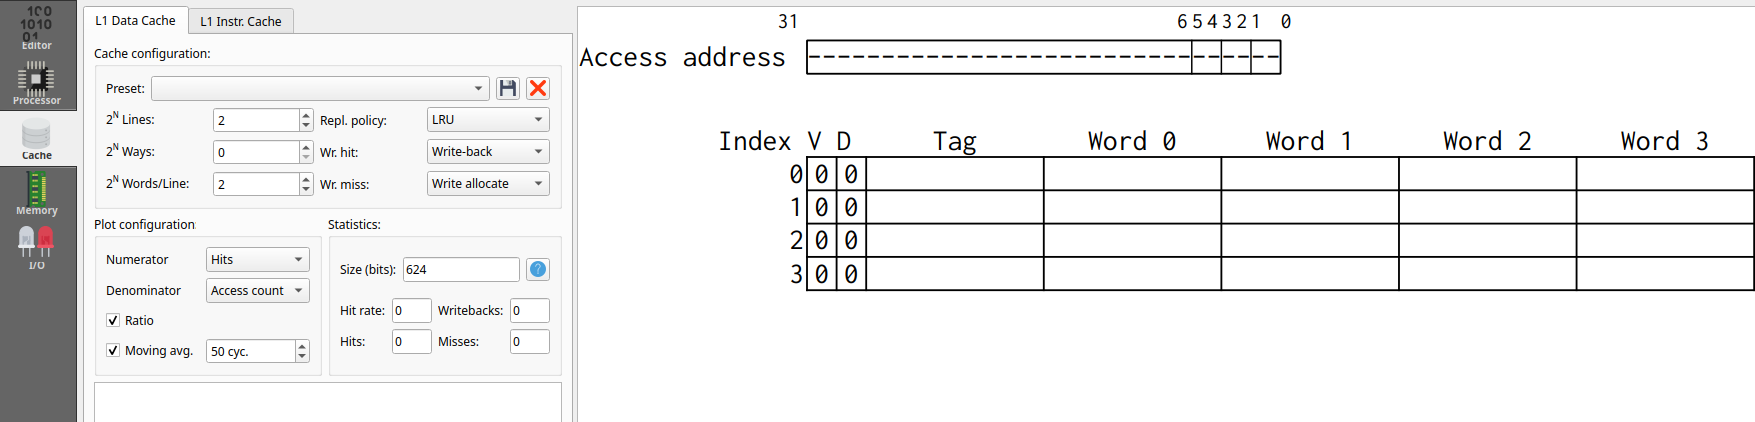

Los accesos a datos en este programa se producen únicamente al ejecutar la instrucción de carga ubicada en la dirección 18: `    18:        0004a603        lw x12 0 x9`. La primera vez que se ejecuta, el registro x9 vale 0x10000000, por lo que se tratará de leer los 4 bytes (palabra) entre las direcciones direcciones 0x10000000 y 0x1000003. Según vemos, el campo index vale 0; al acceder al índice 0, el bit de válido está a 0, por lo que se produce un fallo de caché. Se obtiene una copia del bloque desde la memoria principal con cuatro palabras (direcciones 0x10000000 a la 0x10000015), se inserta en el índice 0 de la caché y se establece el bit de válido y los 26 bits de más peso son el tag (0x400000). El procesador lee la palabra indicada por el campo offset (bits 3 al 0), en este caso, la palabra 0, que contiene el valor entero 1.

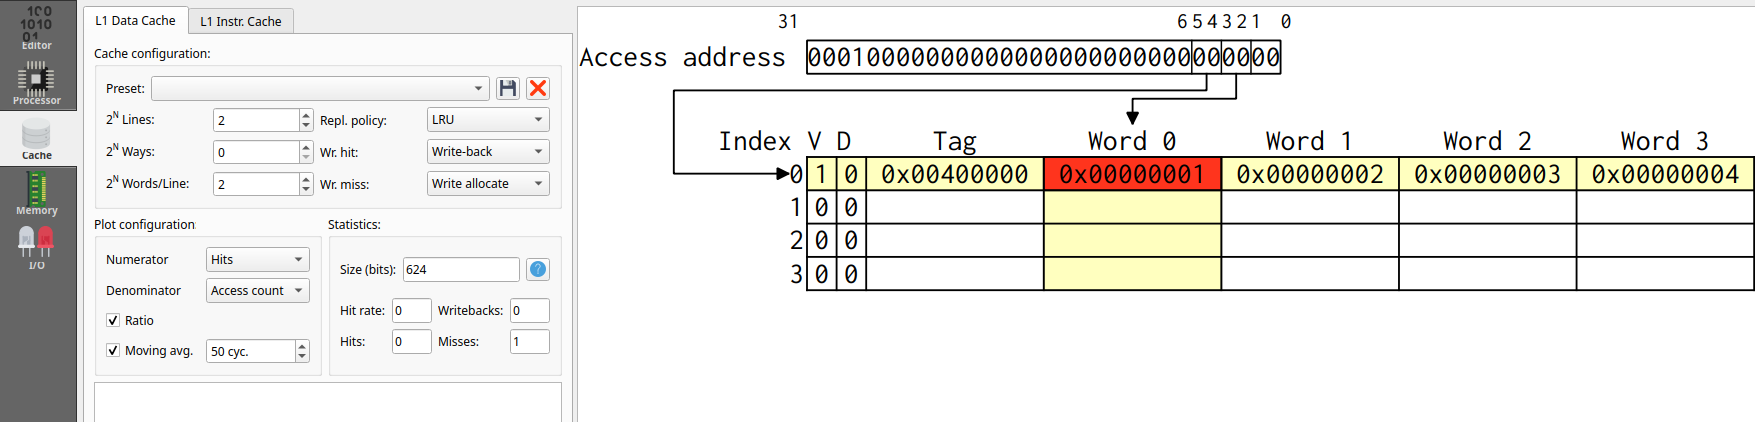

PREGUNTA: Sabiendo que, en la siguiente iteración, el registro x9 verá su valor incrementado en 4, indica a qué índice de la caché accederá, si será un acierto o un fallo, y qué tipo de localidad de referencia es la que está explotando la caché en dicho acceso.

RESPUESTA: Al incrementarse x9 en 4, se accede a la siguiente posición de memoria con índice 10 en la caché. Será un fallo. Este acceso aprovecha la localidad espacial, ya que se trabaja con una dirección cercana a la anterior.



Termina de simular la ejecución del programa y responde a las siguientes preguntas.

PREGUNTA: ¿Cuántos accesos a datos se realizan en total en el programa? ¿Cuántos aciertos y cuántos fallos? Indica la tasa de acierto, y compara el valor de dicha tasa para la L1D y la L1I, indicando si crees que el programa exhibe un nivel de localidad de referencia similar, inferior o superior al que exhibe en el acceso a las instrucciones.

RESPUESTA: Se accede a datos 16 veces, con 12 aciertos y 4 fallos, con una tasa de acierto del 0.75. La tasa de acierto en instrucciones L1I es del 0.9626. Como la tasa de acierto en datos es menor, se aprovecha menos la localidad en accesos a datos que en accesos a instrucciones.



Modifica el código para introducir un segundo recorrido del array, en el que el valor de cada elemento se sustituye por la suma de todos los elementos, calculada en el recorrido anterior. Basta con copiar y pegar el siguiente código, y luego simular de nuevo la ejecución observando el acceso a la caché de datos a partir de la instrucción situada a partir de la etiqueta `loop2`:

```
      .data
array:  .word 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16

      .text
main: 

    la x9, array            # “load address”
    add x10,x0,x0           # sum=0
    add x11,x0,x0           # i=0
    addi x13,x0,16          # 16 elementos en el array
loop:
    bge x11,x13,done        # jump if i>=16
    lw x12, 0(x9)           # leer array[i] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]
    addi x11,x11,1          # ++i
    j loop
done: 
    li a7,1                 # printInt (a0=x10: sum)
    ecall
    
    la x9, array            # “load address”
    add x11,x0,x0           # i=0
    addi x13,x0,16          # 16 elementos en el array
loop2:
    bge x11,x13,done2       # jump if i>=16
    sw x10, 0(x9)           # escribir en array[i] sum
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]
    addi x11,x11,1          # ++i
    j loop2
done2: 
    li a7,10                # exit
    ecall
```

PREGUNTA: ¿En qué cambia el patrón de acceso a datos? Indica de nuevo aciertos, fallos y tasa de acierto, y compara con el código anterior.

RESPUESTA: En que ahora hay dos bucles. En L1D hay un total de 28 aciertos y 4 fallos. Además, la tasa de acierto es del 0.875.



### Localidad en el acceso a instrucciones

El siguiente programa realiza exactamente la misma función que el anterior (suma los elementos del array), pero sin utilizar ningún bucle para recorrer el array. Como ves, el número de instrucciones que contiene el programa es mucho mayor que el anterior.

Copia el código y pégalo en Ripes, y simula su ejecución observando el comportamiento de la caché de instrucciones.

```
      .data
array:  .word 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16

      .text
main: 

    la x9, array            # “load address”
    add x10,x0,x0           # sum=0
    add x11,x0,x0           # i=0

    lw x12, 0(x9)           # leer array[0] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[1] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[2] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[3] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[4] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[5] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[6] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[7] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[8] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[9] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[10] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[11] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[12] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[13] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[14] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

    lw x12, 0(x9)           # leer array[15] en x12
    add x10,x10,x12         # sum += ...
    addi x9,x9,4            # Dirección del siguiente elemento: array[i+1]

done: 
    li a7,1                 # printInt (a0=x10: sum)
    ecall
    li a7,10                # exit
    ecall
```

PREGUNTA: A la vista del número de aciertos y fallos de caché que se producen en la L1I, ¿qué conclusiones sacas acerca de la localidad de referencia que exhibe este programa en lo que respecta a las instrucciones?

RESPUESTA: Al no haber bucles, el programa aprovecha en parte la localidad espacial, pero al ejecutar repetidamente las mismas instrucciones, no se aprovecha esta localidad por completo lo que provoca fallos en caché.


PREGUNTA: A la vista del número de aciertos y fallos de caché que se producen en la L1I, ¿cuántas instrucciones se han ejecutado en total para completar el programa? Explica las razones de las diferencias encontradas.

RESPUESTA: Se han ejecutado 56 instrucciones. Mientras que el primer código usa bucles aprovechando así la localidad temporal en la caché, el segundo, al no tener bucles repite instrucciones continuamente aumentando los fallos en caché(aunque esto último ya lo he mencionado en la respuesta anterior, lo vuelvo a decir aquí para explicar las diferencias entre los dos códigos).



**FIN DEL CUADERNO** (*no borres esta celda*)

@@@@ practica6a-cache-boletin.ipynb @@@@